In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

In [3]:
## set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.np_random.seed(seed)

In [4]:
class Actor(nn.Module):
    def __init__(self,obs_space,hidden_dim,action_space,device):
        super(Actor,self).__init__()
        self.device = device
        ## Actor:state->hidden
        self.Actor = nn.Sequential(
            nn.Linear(obs_space,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2,hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, action_space),
            nn.Softmax(dim=1)
        )        
        
    def forward(self,state):
        state = torch.Tensor(state.reshape(1,-1)).to(self.device)
        return self.Actor(state)
    
    
class Critic(nn.Module):
    def __init__(self,obs_space,hidden_dim,action_space,device):
        super(Critic,self).__init__()
        self.device = device
        self.Critic = nn.Sequential(
            nn.Linear(obs_space,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2,hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, action_space)
        )

    def forward(self,state):
        state = torch.Tensor(state.reshape(1,-1)).to(self.device)
        return self.Critic(state)

In [5]:
## agent
class ACAgent():
    def __init__(self, env, hidden_dim, gamma = 0.9, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.Actor = Actor(self.obs_space, hidden_dim, self.action_len, self.device).to(self.device)
        self.Critic = Critic(self.obs_space, hidden_dim, self.action_len, self.device).to(self.device)
        
        self.loss_fn = nn.MSELoss()
        self.actor_optim = torch.optim.Adam(self.Actor.parameters(), lr = learning_rate)
        self.critic_optim = torch.optim.Adam(self.Critic.parameters(), lr = learning_rate)
        
        self.gamma = gamma
        
    def policy(self, state):
        dist = self.Actor(state)
        action = Categorical(dist).sample()
        return action.item()
    
    def learn(self, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        while not is_end:
            ## 1.choose an action a0
            a0 = self.policy(s0)
            ## 2.make a step
            s1, reward, is_end, _ = self.env.step(a0)
            ## 3.randomly sample a1
            a1 = self.policy(s1)
            ## 4.value network
            q0 = self.Critic(s0)
            q1 = self.Critic(s1)
            ## 5.compute TD-error
            target_q = reward + self.gamma*q1[:,a1]*(1-is_end)
            ## 6.update value network
            critic_loss = self.loss_fn(target_q, q0[:,a0])
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()
            ## 7.update policy network
            pg = torch.log(self.Actor(s0))[:,a0]
            delta = target_q - q0[:,a0]
            actor_loss = -pg * delta.detach()
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()  
            ## next
            s0 = s1
            episode_reward += reward
        return episode_reward

In [6]:
ac_agent = ACAgent(env, hidden_dim = 16, gamma = 0.99, learning_rate = 1e-3)
MAX_EPISODE = 3000
ac_episode_reward = []
average_100_step = []

for e in tqdm(range(MAX_EPISODE)):
    reward = ac_agent.learn(display = False)
    ac_episode_reward.append(reward)
    avg_mean = np.mean(ac_episode_reward[-100:])
    average_100_step.append(avg_mean)   
    if e%100 == 0:
        print('episode:',e,'reward:',reward)

  0%|                                                                                 | 1/3000 [00:00<20:08,  2.48it/s]

episode: 0 reward: 45.0


  3%|██▋                                                                            | 101/3000 [00:15<10:40,  4.52it/s]

episode: 100 reward: 25.0


  7%|█████▎                                                                         | 203/3000 [00:31<06:07,  7.62it/s]

episode: 200 reward: 24.0


 10%|███████▉                                                                       | 302/3000 [00:46<05:54,  7.60it/s]

episode: 300 reward: 15.0


 13%|██████████▌                                                                    | 401/3000 [01:00<08:26,  5.13it/s]

episode: 400 reward: 39.0


 17%|█████████████▏                                                                 | 501/3000 [01:16<09:17,  4.49it/s]

episode: 500 reward: 43.0


 20%|███████████████▊                                                               | 601/3000 [01:30<06:11,  6.46it/s]

episode: 600 reward: 22.0


 23%|██████████████████▍                                                            | 701/3000 [02:14<23:03,  1.66it/s]

episode: 700 reward: 51.0


 27%|█████████████████████                                                          | 801/3000 [03:09<14:48,  2.48it/s]

episode: 800 reward: 52.0


 30%|███████████████████████▋                                                       | 901/3000 [03:48<14:35,  2.40it/s]

episode: 900 reward: 47.0


 33%|██████████████████████████                                                    | 1001/3000 [04:16<11:01,  3.02it/s]

episode: 1000 reward: 37.0


 37%|████████████████████████████▋                                                 | 1101/3000 [05:41<40:38,  1.28s/it]

episode: 1100 reward: 155.0


 40%|███████████████████████████████▏                                              | 1201/3000 [07:28<17:43,  1.69it/s]

episode: 1200 reward: 88.0


 43%|█████████████████████████████████▊                                            | 1301/3000 [09:04<27:05,  1.05it/s]

episode: 1300 reward: 130.0


 47%|████████████████████████████████████▍                                         | 1401/3000 [11:04<25:08,  1.06it/s]

episode: 1400 reward: 142.0


 50%|███████████████████████████████████████                                       | 1501/3000 [12:48<31:30,  1.26s/it]

episode: 1500 reward: 149.0


 53%|█████████████████████████████████████████▋                                    | 1601/3000 [14:36<19:47,  1.18it/s]

episode: 1600 reward: 99.0


 57%|████████████████████████████████████████████▏                                 | 1701/3000 [16:15<26:31,  1.23s/it]

episode: 1700 reward: 146.0


 60%|██████████████████████████████████████████████▊                               | 1801/3000 [18:14<20:43,  1.04s/it]

episode: 1800 reward: 200.0


 63%|█████████████████████████████████████████████████▍                            | 1901/3000 [19:54<13:43,  1.33it/s]

episode: 1900 reward: 129.0


 67%|████████████████████████████████████████████████████                          | 2001/3000 [21:26<16:35,  1.00it/s]

episode: 2000 reward: 104.0


 70%|██████████████████████████████████████████████████████▋                       | 2101/3000 [23:17<09:09,  1.64it/s]

episode: 2100 reward: 60.0


 73%|█████████████████████████████████████████████████████████▏                    | 2201/3000 [24:32<11:00,  1.21it/s]

episode: 2200 reward: 120.0


 77%|███████████████████████████████████████████████████████████▊                  | 2301/3000 [25:28<05:18,  2.20it/s]

episode: 2300 reward: 43.0


 80%|██████████████████████████████████████████████████████████████▍               | 2401/3000 [26:11<04:21,  2.29it/s]

episode: 2400 reward: 71.0


 83%|█████████████████████████████████████████████████████████████████             | 2501/3000 [27:05<09:12,  1.11s/it]

episode: 2500 reward: 117.0


 87%|███████████████████████████████████████████████████████████████████▋          | 2601/3000 [28:26<04:35,  1.45it/s]

episode: 2600 reward: 85.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 2701/3000 [29:54<05:21,  1.08s/it]

episode: 2700 reward: 200.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 2801/3000 [31:23<02:11,  1.51it/s]

episode: 2800 reward: 102.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2901/3000 [33:05<01:04,  1.52it/s]

episode: 2900 reward: 87.0


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [34:17<00:00,  1.46it/s]


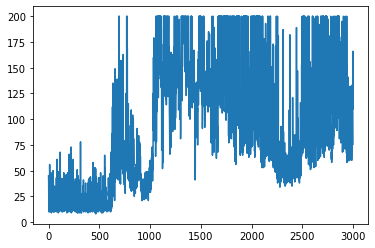

In [7]:
plt.plot(ac_episode_reward)

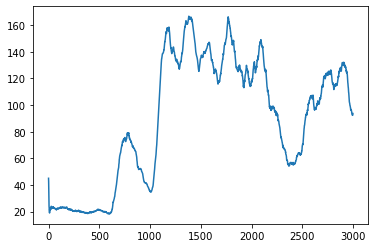

In [8]:
plt.plot(average_100_step)

In [9]:
ac_curve = np.array(average_100_step)
np.save('curve\AC', ac_curve)